In [69]:
bikedata = pd.read_csv('./march_hello.csv')
bikedata.head(3)

,Title,CompanyId,BicycleNo,OrderId,StartTime,StartLongitude,StartLatitude,EndTime,EndLongitude,EndLatitude,...,typecode,gridcode,entr_location,tel,postcode,tag,longitude,latitude,functionaltype,trafficaccessibility
0,0,BrandOne,1,1,2021/03/01 00:00:05,121.558125,29.854842,2021/03/01 00:06:55,121.552669,29.867710,...,130103.0,4.421642e+09,NaN,NaN,NaN,NaN,121.558219,29.854597,6,0
1,1,BrandOne,2,2,2021/03/01 00:00:21,121.554929,29.833805,2021/03/01 00:07:24,121.560528,29.825347,...,120201.0,4.421640e+09,"121.554747,29.833818",NaN,NaN,NaN,121.554841,29.833894,4,0
2,2,BrandOne,3,3,2021/03/01 00:00:25,121.578817,29.876072,2021/03/01 00:06:01,121.573239,29.861707,...,150906.0,4.421646e+09,"121.578671,29.875799",NaN,NaN,NaN,121.578531,29.875763,17,1


In [78]:
ningbo_admin = gpd.read_file(r'./ningbo.json')
bikedata = tbd.clean_outofshape(bikedata, ningbo_admin, col=['StartLongitude', 'StartLatitude'], accuracy=500)
bikedata = tbd.clean_outofshape(bikedata, ningbo_admin, col=['EndLongitude','EndLatitude'], accuracy=500)

In [79]:
bounds = ( 121.257092, 29.720824,121.658294, 37.549171)
params = tbd.grid_params(bounds,accuracy = 500)
#集计OD
od_gdf = tbd.odagg_grid(bikedata, params, col=['StartLongitude','StartLatitude', 'EndLongitude','EndLatitude'])
od_gdf.head(5)

/Users/monica/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,SLONCOL,SLATCOL,ELONCOL,ELATCOL,count,SHBLON,SHBLAT,EHBLON,EHBLAT,geometry
0,37,44,39,42,1,121.456921,29.918675,121.467723,29.909681,"LINESTRING (121.45692 29.91867, 121.46772 29.9..."
14702,57,19,58,32,1,121.564937,29.806259,121.570338,29.864715,"LINESTRING (121.56494 29.80626, 121.57034 29.8..."
14703,57,19,58,36,1,121.564937,29.806259,121.570338,29.882702,"LINESTRING (121.56494 29.80626, 121.57034 29.8..."
14704,57,19,59,17,1,121.564937,29.806259,121.575739,29.797266,"LINESTRING (121.56494 29.80626, 121.57574 29.7..."
14709,57,19,59,24,1,121.564937,29.806259,121.575739,29.828743,"LINESTRING (121.56494 29.80626, 121.57574 29.8..."


In [80]:
outputpath='grid.csv'
od_gdf.to_csv(outputpath,sep=',',columns=['SLONCOL', 'SLATCOL','geometry'])

In [81]:
 #栅格化代码
import math
#定义一个测试栅格划的经纬度
testlon = 121.456921
testlat = 29.918675

#划定栅格划分范围
lon1 = 121.257092
lon2 = 121.658294
lat1 = 29.720824
lat2 = 37.549171

latStart = min(lat1, lat2);
lonStart = min(lon1, lon2);

#定义栅格大小(单位m)
accuracy = 500;

#计算栅格的经纬度增加量大小▲Lon和▲Lat
deltaLon = accuracy * 360 / (2 * math.pi * 6371004 * math.cos((lat1 + lat2) * math.pi / 360));
deltaLat = accuracy * 360 / (2 * math.pi * 6371004);

#计算栅格的经纬度编号
LONCOL=divmod(float(testlon) - (lonStart - deltaLon / 2) , deltaLon)[0]
LATCOL=divmod(float(testlat) - (latStart - deltaLat / 2) , deltaLat)[0]

#计算栅格的中心点经纬度
HBLON = LONCOL*deltaLon + (lonStart - deltaLon / 2)#格子编号*格子宽+起始横坐标-半个格子宽=格子中心横坐标
HBLAT = LATCOL*deltaLat + (latStart - deltaLat / 2)

#把算好的东西print出来看看
LONCOL,LATCOL,HBLON,HBLAT,deltaLon,deltaLat

(37.0,
 44.0,
 121.45422078817506,
 29.9164263264794,
 0.005400788717124769,
 0.004496605206422906)

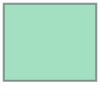

In [50]:
from shapely.geometry import Point,Polygon,shape
Polygon([(HBLON+deltaLon/2,HBLAT-deltaLat/2),
        (HBLON+deltaLon/2,HBLAT+deltaLat/2),
        (HBLON-deltaLon/2,HBLAT+deltaLat/2),
        (HBLON-deltaLon/2,HBLAT-deltaLat/2)])



<AxesSubplot:>

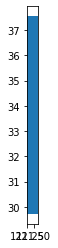

In [54]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Point,Polygon,shape


#定义空的geopandas表
data = geopandas.GeoDataFrame()

#定义空的list，后面循环一次就往里面加东西
LONCOL = []
LATCOL = []
geometry = []
HBLON1 = []
HBLAT1 = []

#计算总共要生成多少个栅格
#lon方向是lonsnum个栅格
lonsnum = int((lon2-lon1)/deltaLon)+1
#lat方向是latsnum个栅格
latsnum = int((lat2-lat1)/deltaLat)+1

for i in range(lonsnum):
    for j in range(latsnum):

        HBLON = i*deltaLon + (lonStart - deltaLon / 2)
        HBLAT = j*deltaLat + (latStart - deltaLat / 2)
        #把生成的数据都加入到前面定义的空list里面
        LONCOL.append(i)
        LATCOL.append(j)
        HBLON1.append(HBLON)
        HBLAT1.append(HBLAT)
        
        #生成栅格的Polygon形状
        #这里我们用周围的栅格推算三个顶点的位置，否则生成的栅格因为小数点取值的问题会出现小缝，无法完美覆盖
        HBLON_1 = (i+1)*deltaLon + (lonStart - deltaLon / 2)
        HBLAT_1 = (j+1)*deltaLat + (latStart - deltaLat / 2)
        geometry.append(Polygon([
        (HBLON-deltaLon/2,HBLAT-deltaLat/2),
        (HBLON_1-deltaLon/2,HBLAT-deltaLat/2),
        (HBLON_1-deltaLon/2,HBLAT_1-deltaLat/2),
        (HBLON-deltaLon/2,HBLAT_1-deltaLat/2)]))
        
#为geopandas文件的每一列赋值为刚刚的list
data['LONCOL'] = LONCOL
data['LATCOL'] = LATCOL
data['HBLON'] = HBLON1
data['HBLAT'] = HBLAT1
data['geometry'] = geometry

data.plot()

In [55]:
data.head(5)

,LONCOL,LATCOL,HBLON,HBLAT,geometry
0,0,0,121.254392,29.718576,"POLYGON ((121.25169 29.71633, 121.25709 29.716..."
1,0,1,121.254392,29.723072,"POLYGON ((121.25169 29.72082, 121.25709 29.720..."
2,0,2,121.254392,29.727569,"POLYGON ((121.25169 29.72532, 121.25709 29.725..."
3,0,3,121.254392,29.732066,"POLYGON ((121.25169 29.72982, 121.25709 29.729..."
4,0,4,121.254392,29.736562,"POLYGON ((121.25169 29.73431, 121.25709 29.734..."


In [58]:
outputpath='grid.csv'
data.to_csv(outputpath,sep=',',columns=['LONCOL','LATCOL','HBLON','HBLAT','geometry'])

In [85]:
od_gdf = od_gdf[-od_gdf['EHBLON'].isnull()].copy()
od_gdf['SLONCOL'] = ((od_gdf['SHBLON'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
od_gdf['SLATCOL'] = ((od_gdf['SHBLAT'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
od_gdf['SHBLON'] = od_gdf['SLONCOL']*deltaLon + (lonStart - deltaLon / 2)
od_gdf['SHBLAT'] = od_gdf['SLATCOL']*deltaLat + (latStart - deltaLat / 2)
od_gdf['ELONCOL'] = ((od_gdf['EHBLON'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
od_gdf['ELATCOL'] = ((od_gdf['EHBLAT'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
od_gdf['EHBLON'] = od_gdf['ELONCOL']*deltaLon + (lonStart - deltaLon / 2)
od_gdf['EHBLAT'] = od_gdf['ELATCOL']*deltaLat + (latStart - deltaLat / 2)
#筛选去掉起点终点在同一个格子里的OD
od_gdf = od_gdf[-((od_gdf['SLONCOL']==od_gdf['ELONCOL'])&(od_gdf['SLATCOL']==od_gdf['ELATCOL']))]
#筛选去掉不在研究范围内的栅格
od_gdf = od_gdf[(od_gdf['SLONCOL']>=0) & (od_gdf['SLATCOL']>=0) &(od_gdf['ELONCOL']>=0) & (od_gdf['ELATCOL']>=0)&
(od_gdf['SLONCOL']<=lonsnum) & (od_gdf['SLATCOL']<=latsnum) &(od_gdf['ELONCOL']<=lonsnum) & (od_gdf['ELATCOL']<=latsnum)]
###################################################################################
od_gdf.head(5)


,SLONCOL,SLATCOL,ELONCOL,ELATCOL,count,SHBLON,SHBLAT,EHBLON,EHBLAT,geometry
0,37,44,39,42,1,121.454221,29.916426,121.465022,29.907433,"LINESTRING (121.45692 29.91867, 121.46772 29.9..."
14702,57,19,58,32,1,121.562237,29.804011,121.567637,29.862467,"LINESTRING (121.56494 29.80626, 121.57034 29.8..."
14703,57,19,58,36,1,121.562237,29.804011,121.567637,29.880453,"LINESTRING (121.56494 29.80626, 121.57034 29.8..."
14704,57,19,59,17,1,121.562237,29.804011,121.573038,29.795018,"LINESTRING (121.56494 29.80626, 121.57574 29.7..."
14709,57,19,59,24,1,121.562237,29.804011,121.573038,29.826494,"LINESTRING (121.56494 29.80626, 121.57574 29.8..."
